In [1]:
import plotly
import plotly.graph_objs as go
import plotly.express as px 
from plotly.offline import init_notebook_mode, iplot

import numpy as np
import pandas as pd 

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn import decomposition

init_notebook_mode(connected=True)  

In [2]:
data_dir = ''
ww_df = pd.read_csv(data_dir + 'extra_ww.csv')
ww_df = ww_df[ww_df['Gender'] == 'Both sexes'].reset_index(drop=True)
print("Columns", ww_df.columns)
num_cols = [
    'Year',
    'arg', 'cpi', 'edu', 'employ',
    'exchange', 'gdp', 'green', 'income', 'pop', 'tax', 'LifeLadder',
    'LogGDPPerCapita', 'SocialSupport', 'Expectancy', 'Freedom',
    'Generosity', 'Corruption', 'PositiveAffect', 'NegativeAffect'
]
cat_col = ['ParentLocation']

# One-Hot encode categorical variables
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(ww_df[cat_col])
print("Categories", enc.categories_)
# Merge One-Hot varables with original dataset
enc_df = pd.DataFrame(enc.fit_transform(ww_df[cat_col]).toarray())
enc_df.columns = enc.categories_[0]
ww_df = ww_df.join(enc_df)

# select continous years of data
ww_df_ts = ww_df[(ww_df['Year'] >= 2013) & (ww_df['Year'] <= 2018)]

# cube root transformation
cbrt_cols = ['cpi', 'exchange', 'gdp', 
            'green', 'income', 'pop']
for col in cbrt_cols:
    cbrt_col_name = 'cbrt_' + col
    ww_df_ts[cbrt_col_name] = np.cbrt(ww_df_ts[col])

# numerical columns, pca columns, categorical columns
num_cols_m1 = ['edu', 'employ', 'LogGDPPerCapita', 'cbrt_income', 'pop', 'tax']
pca_cols_m1 = ['LifeLadder', 'SocialSupport', 'Expectancy', 'Freedom', 'PositiveAffect', 'NegativeAffect']
cat_cols_m1 = list(enc_df.columns)

# normalize
scaler = preprocessing.MinMaxScaler()
data_scaled = scaler.fit_transform(ww_df_ts[num_cols_m1+pca_cols_m1])
data_normalized = pd.DataFrame(data_scaled, columns = [num_cols_m1+pca_cols_m1])
ww_df_ts[num_cols_m1+pca_cols_m1] = data_normalized

# fillna
imputer = KNNImputer(n_neighbors=3)
ww_df_ts[num_cols_m1+pca_cols_m1] = imputer.fit_transform(ww_df_ts[num_cols_m1+pca_cols_m1])
# ww_df_ts[num_cols_m1+pca_cols_m1].info() # check no NA values

# PCA
pca = decomposition.PCA(n_components=3)
pca.fit(ww_df_ts[pca_cols_m1])
pca_trans_cols_m1 = pca.transform(ww_df_ts[pca_cols_m1])
pca_lst = ['pca_1', 'pca_2', 'pca_3']
ww_df_ts[pca_lst] = pd.DataFrame(pca_trans_cols_m1)

# Define Columns
all_num_cols = num_cols_m1 + pca_lst
feature_cols = all_num_cols + cat_cols_m1
add_cols     = ['Year', 'Location']
df = ww_df_ts[feature_cols + add_cols + ['Value']]

Columns Index(['ParentLocationCode', 'ParentLocation', 'SpatialDimValueCode',
       'Location', 'Year', 'Gender', 'Value', 'arg', 'cpi', 'edu', 'employ',
       'exchange', 'gdp', 'green', 'income', 'pop', 'tax', 'LifeLadder',
       'LogGDPPerCapita', 'SocialSupport', 'Expectancy', 'Freedom',
       'Generosity', 'Corruption', 'PositiveAffect', 'NegativeAffect'],
      dtype='object')
Categories [array(['Africa', 'Americas', 'Eastern Mediterranean', 'Europe',
       'South-East Asia', 'Western Pacific'], dtype=object)]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [3]:
# preprocess, including time info
# location annual progression - world annual (mean) progression from 2013 to 2018

def getProgress(dff,cols,years):
    d = dict()
    d["Year"] = list(years)
    for col in cols:
        res = [0] # init 2013
        L = list(dff[col])
        for i in range(1,len(L)):
            if L[i-1] == 0: 
                res.append(0)
            else:
                res.append((L[i] - L[i-1]) / L[i-1]) 
        d[col+"_prog"] = res
    return pd.DataFrame(d)

def vsWorld(countries,df_ww,dfs_country,numeric_cols):
    L = []
    for i in range(len(countries)):
        d = dict()
        d["Location"] = np.repeat(countries[i],len(range(2013,2019)))
        d["Year"] = range(2013,2019)
        df_country = dfs_country[i]
        for X in numeric_cols:
            d[X+"_relprog"] = (df_country[X+"_prog"] - df_ww[X+"_prog"])
        L.append(pd.DataFrame(d))
    return pd.concat(L)


df_ww_annual_avg = df.groupby(["Year"]).mean()
df_ww_annual_progress = getProgress(df_ww_annual_avg,all_num_cols,df_ww_annual_avg.index)
df_count = df.groupby(["Location","Year"]).sum()
countries = df["Location"].unique()
dfs_country = [getProgress(df_count.loc[(c,)],all_num_cols,range(2013,2019)) for c in countries]
df_all = df.merge(vsWorld(countries, df_ww_annual_progress,dfs_country,all_num_cols),how="left") 


,edu,employ,LogGDPPerCapita,cbrt_income,pop,tax,pca_1,pca_2,pca_3,Africa,...,Value,edu_relprog,employ_relprog,LogGDPPerCapita_relprog,cbrt_income_relprog,pop_relprog,tax_relprog,pca_1_relprog,pca_2_relprog,pca_3_relprog
0,0.435265,0.327886,0.798337,0.242478,0.000809,0.388227,-0.391721,0.117101,0.168434,1.0,...,10.7,-0.018273,0.010655,-0.008991,0.009258,0.009082,-0.003805,-0.767715,-0.233795,-0.502952
1,0.508801,0.479838,0.569910,0.369193,0.033583,0.460127,-0.004758,-0.009640,-0.006987,0.0,...,10.9,-0.018273,0.010655,-0.008991,-0.016265,-0.001205,-0.003805,-0.767715,-0.233795,-0.502952


In [81]:
# Model: Multiple Linear Regression
# Data: Original features

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
np.random.seed(42)

X_m1 = df_all[num_cols_m1 + cat_cols_m1 + pca_lst]
Y_m1 = df_all['Value']


# Record Average Train and Validation Accuracy
coefficients = []
train_acc_lst, test_acc_lst = [], []
for i in range(20):
    X_m1_train, X_m1_test,Y_m1_train, Y_m1_test = train_test_split(X_m1, Y_m1, test_size =0.2)
    lr_model = LinearRegression()
    lr_model.fit(X_m1_train, Y_m1_train)
    coefficients.append(lr_model.coef_)
    train_acc_lst.append(lr_model.score(X_m1_train, Y_m1_train))
    test_acc_lst.append(lr_model.score(X_m1_test, Y_m1_test))
train_acc_lst, test_acc_lst = np.array(train_acc_lst), np.array(test_acc_lst)
print(np.mean(train_acc_lst), np.mean(test_acc_lst))
naive = pd.DataFrame({'Feature':X_m1_train.columns, 
              'mean coefficients' : sum(coefficients)/len(coefficients)})
naive.to_csv("naive_coeffi.csv",index=False)

0.49722232954605544 0.4856230402951719


In [9]:
# Model: Multiple Linear Regression
# Data: Relative numerical features + one-hot categorical features

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
np.random.seed(42)
relative_features = [col + "_relprog" for col in num_cols_m1 + pca_lst]
X_m2 = df_all[relative_features + cat_cols_m1]
Y_m2 = df_all['Value']


# Record Average Train and Validation Accuracy
train_acc_lst_m2, test_acc_lst_m2 = [], []
for i in range(20):
    X_m2_train, X_m2_test,Y_m2_train, Y_m2_test = train_test_split(X_m2, Y_m2, test_size =0.2)
    lr_model_2 = LinearRegression()
    lr_model_2.fit(X_m2_train, Y_m2_train)
    train_acc_lst_m2.append(lr_model_2.score(X_m2_train, Y_m2_train))
    test_acc_lst_m2.append(lr_model_2.score(X_m2_test, Y_m2_test))
train_acc_lst, test_acc_lst = np.array(train_acc_lst_m2), np.array(test_acc_lst_m2)
print(np.mean(train_acc_lst_m2), np.mean(test_acc_lst_m2))

0.41960408345367073 0.3333617642126903


In [82]:
# Model: Lasso Linear Regression
# Data: Original Features

from sklearn import linear_model
from sklearn.model_selection import train_test_split

coefficients_3 = []
# Record Average Train and Validation Accuracy
train_acc_lst_m3, test_acc_lst_m3 = [], []
for i in range(20):
    X_m3_train, X_m3_test,Y_m3_train, Y_m3_test = train_test_split(X_m1, Y_m1, test_size =0.2)
    lr_model = linear_model.Lasso(alpha=0.01,max_iter=100000,tol=1e-1)
    lr_model.fit(X_m3_train, Y_m3_train)
    coefficients_3.append(lr_model.coef_)
    train_acc_lst_m3.append(lr_model.score(X_m3_train, Y_m3_train))
    test_acc_lst_m3.append(lr_model.score(X_m3_test, Y_m3_test))
train_acc_lst_m3, test_acc_lst_m3 = np.array(train_acc_lst_m3), np.array(test_acc_lst_m3)
print(np.mean(train_acc_lst_m3), np.mean(test_acc_lst_m3))
lasso = pd.DataFrame({'Feature':X_m1_train.columns, 
              'mean coefficients' : sum(coefficients_3)/len(coefficients_3)})
lasso.to_csv("lasso_coeffi.csv",index=False)

0.49076008105404306 0.5052438946183064


In [15]:
# Model: Lasso Linear Regression
# Data: Relative numerical features + one-hot categorical features

from sklearn import linear_model
from sklearn.model_selection import train_test_split

# Record Average Train and Validation Accuracy
train_acc_lst_m3, test_acc_lst_m3 = [], []
for i in range(20):
    X_m3_train, X_m3_test,Y_m3_train, Y_m3_test = train_test_split(X_m2, Y_m2, test_size =0.2)
    lr_model = linear_model.Lasso(alpha=0.01,max_iter=100000,tol=1e-1)
    lr_model.fit(X_m3_train, Y_m3_train)
    train_acc_lst_m3.append(lr_model.score(X_m3_train, Y_m3_train))
    test_acc_lst_m3.append(lr_model.score(X_m3_test, Y_m3_test))
train_acc_lst_m3, test_acc_lst_m3 = np.array(train_acc_lst_m3), np.array(test_acc_lst_m3)
print(np.mean(train_acc_lst_m3), np.mean(test_acc_lst_m3))

0.41475430337243013 0.32302818683824197


In [83]:
# Model: Ridge Linear Regression
# Data: Original Features

from sklearn import linear_model
from sklearn.model_selection import train_test_split

coefficients_5 = []
# Record Average Train and Validation Accuracy
train_acc_lst_m5, test_acc_lst_m5 = [], []
for i in range(20):
    X_m5_train, X_m5_test,Y_m5_train, Y_m5_test = train_test_split(X_m1, Y_m1, test_size =0.2)
    lr_model = linear_model.Ridge(alpha=1.0,max_iter=100000,tol=1e-1)
    lr_model.fit(X_m5_train, Y_m5_train)
    coefficients_5.append(lr_model.coef_)
    train_acc_lst_m5.append(lr_model.score(X_m5_train, Y_m5_train))
    test_acc_lst_m5.append(lr_model.score(X_m5_test, Y_m5_test))
train_acc_lst_m5, test_acc_lst_m5 = np.array(train_acc_lst_m5), np.array(test_acc_lst_m5)
print(np.mean(train_acc_lst_m5), np.mean(test_acc_lst_m5))
ridge = pd.DataFrame({'Feature':X_m1_train.columns, 
              'mean coefficients' : sum(coefficients_5)/len(coefficients_5)})
ridge.to_csv("ridge_coeffi.csv",index=False)

0.4935548632763428 0.4972161204278726


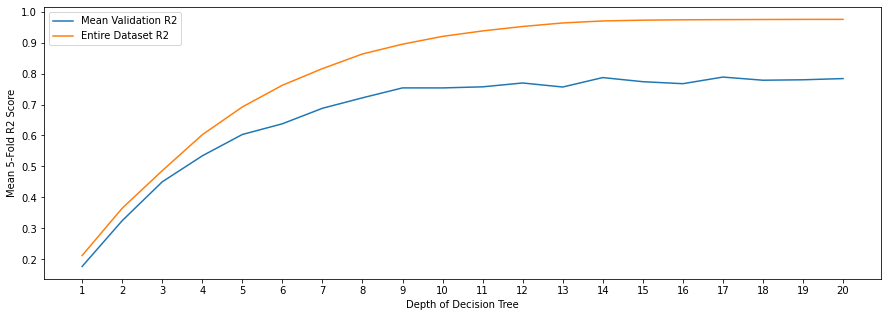

In [75]:
# Model: Decision Tree
# Data: Original features

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz 
from graphviz import Source

np.random.seed(42) 

cv = 5
d_lst = np.arange(1, 21)
mean_acc_score = []
total_acc_score_lst = []
for d in d_lst:
    # train-test split; calculate validation score
    clf = DecisionTreeRegressor(max_depth=d)
    clf_score = cross_val_score(clf, X_m1, Y_m1, cv=cv) # scoring="R2" by default
#     print("d, clf_score", d, clf_score)
    # whole dataset
    clf = DecisionTreeRegressor(max_depth=d)
    clf.fit(X_m1, Y_m1)
    total_acc = clf.score(X_m1, Y_m1)
    mean_clf_score = np.mean(clf_score)
    mean_acc_score.append(mean_clf_score)
    total_acc_score_lst.append(total_acc)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(d_lst, mean_acc_score, label = "Mean Validation R2")
ax.plot(d_lst, total_acc_score_lst, label = "Entire Dataset R2")

ax.set_xlabel('Depth of Decision Tree')
ax.set_ylabel('Mean %d-Fold R2 Score' % cv)
ax.set_xticks(d_lst)
ax.set_ylim(plt.ylim())
ax.legend()

In [76]:
mean_acc_score [8], total_acc_score_lst[8]

(0.7536168341553655, 0.8946870018550763)

In [80]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_text

# Decision Tree feature importance
clf = DecisionTreeRegressor(max_depth=9)
clf.fit(X_m1, Y_m1)
import_lst = clf.feature_importances_.nonzero()
tree_rules = export_text(clf, feature_names=list(X_m1.columns))
#print(tree_rules)

predicted = clf.predict(X_m1, list(Y_m1))
accuracy_df = pd.DataFrame({"predicted":predicted,"truth":Y_m1})

fea_info = [[X_m1.columns[i],  clf.feature_importances_[i]] for i in range(len(X_m1.columns))]
#pd.DataFrame(fea_info, columns=['Feature', 'Importance'])
#list(X_m1.columns)

['edu',
 'employ',
 'LogGDPPerCapita',
 'cbrt_income',
 'pop',
 'tax',
 'Africa',
 'Americas',
 'Eastern Mediterranean',
 'Europe',
 'South-East Asia',
 'Western Pacific',
 'pca_1',
 'pca_2',
 'pca_3']

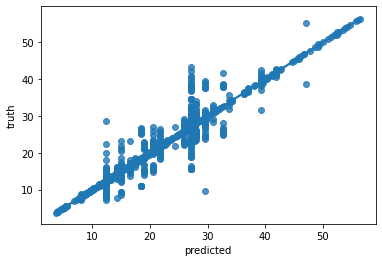

In [55]:
import seaborn as sns
fig = sns.regplot(data=accuracy_df, x="predicted",y="truth")